# Imports des bibliothèques

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
from phyling.ble.nanophyling import NanoPhyling
from tabulate import tabulate

nest_asyncio.apply()  # used in notebook

# Protocole

On réalise un pendule simple en attachant une masse de 1 kg à l’extrémité d’une corde de 60 cm. Le Nano-Phyling est fixé solidement à l’aide de ruban adhésif sur la corde (ou directement sur la masse si c’est plus stable), en veillant à limiter au maximum les mouvements relatifs entre le capteur et le pendule.
L’objectif est d’obtenir une oscillation principalement dans le plan (y,z) : on lance donc le pendule de façon à ce que le mouvement reste majoritairement dans ce plan et que les rotations parasites (torsion de la corde / rotation de la masse) restent faibles.
Avant de démarrer l’acquisition, on met le pendule en oscillation (petite amplitude pour l'approximation des petits angles) puis on lance l’enregistrement du Nano-Phyling : cela permet d’obtenir directement un signal exploitable, sans avoir à recouper systématiquement le début de l’acquisition.

Définition des variables :

In [2]:
m = 1 # masse en kg
l = 0.6 # longueur en m

# Connexion au Nano et prise de données

Les cellules suivantes permettent d’établir la connexion au capteur Nano-Phyling, puis de démarrer l’acquisition des données de la centrale inertielle, suspendue à l’extrémité d’un fil et mise en oscillation par une masse.

Si besoin : exécuter directement la cellule d'import de données locales plutôt que de connexion au Nano-Phyling.

In [ ]:
# Il est possible de récupérer l’adresse du capteur lorsqu’il est connecté
# (dans la fonction calibrate_gyro).

nano = NanoPhyling(
    name="NanoPhyling_42",
    config={
        "rate": 200,
        "data": ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"],
    }
)

Dans un premier temps, on laisse le Nano-Phyling immobile afin de pouvoir calibrer le gyroscope. 

In [ ]:
nano.calibrate_gyro()

In [ ]:
# En fournissant directement l’adresse au lieu du nom, il est possible
# d’ignorer l’étape de scan BLE. L'adresse apparait dans la sortie
# de la cellule de calbiration au dessus

addresses = {
    "NanoPhyling_42": "5E866BBD-FA9A-7153-CF2B-E3FE1EDBAEB3",
}

nano = NanoPhyling(
    address=addresses["NanoPhyling_42"],
    config={
        "rate": 200,
        "data": ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"],
    },
    # on ajuste les valeurs de calibration avec la sortie de la cellule précédente
    gyro_offsets={'x': 2.504009803921569, 'y': -3.710274509803922, 'z': -2.228401960784314},
)

Avant d’exécuter la cellule suivante, on met en mouvement la masse du pendule de manière à ce que l’oscillation s’effectue principalement dans le plan (x,y).

In [ ]:
# Si la durée est définie à None, l’acquisition se poursuit jusqu’à son arrêt manuel
nano.run(duration=15)

# Nom du fichier de sauvegarde
filename = f"data/pendule_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

In [ ]:
# Récupération des données sous forme de DataFrame pandas
df = nano.get_df()

# Affichage des premières lignes du jeu de données
df.head()

# Sauvegarde des données
df.to_csv(filename, index=False)


Autre possibilité : on peut charger directement un fichier local. 

In [3]:
# Option : chargement des données depuis un fichier csv 
df = pd.read_csv("data/pendulum_example.csv")

# Visualisation des données brutes

L’acquisition s’est terminée à t = 40.1 secondes
Il y a 7476 points dans les données
La fréquence d’échantillonnage moyenne est de 186.3 Hz


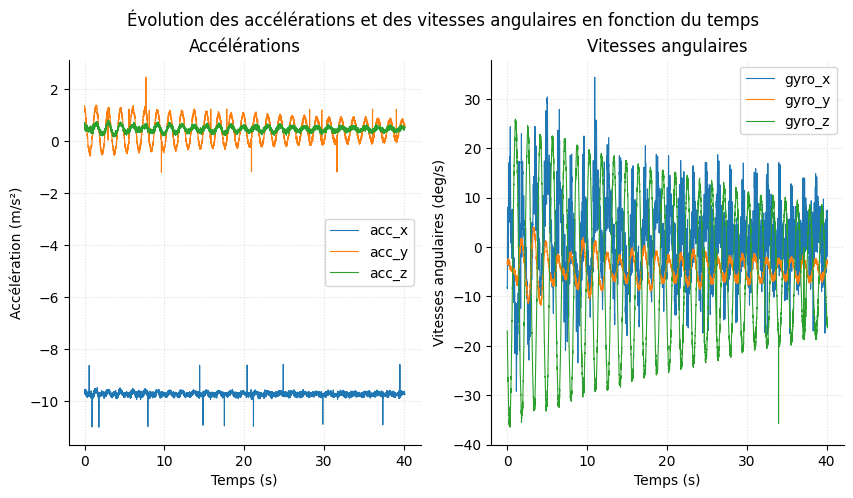

In [4]:
# Exploration des données
print("L’acquisition s’est terminée à t =", round(df["T"].iloc[-1], 1), "secondes")
print("Il y a", df.shape[0], "points dans les données")
print("La fréquence d’échantillonnage moyenne est de", round(df.shape[0] / df["T"].iloc[-1], 1), "Hz")

# Trace les données
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axs[0].plot(df["T"], df["acc_x"], label="acc_x", lw = 0.8)
axs[0].plot(df["T"], df["acc_y"], label="acc_y", lw = 0.8)
axs[0].plot(df["T"], df["acc_z"], label="acc_z", lw = 0.8)
axs[0].set_title("Accélérations")
axs[0].set_xlabel("Temps (s)")
axs[0].set_ylabel("Accélération (m/s²)")
axs[0].legend()
axs[0].grid(alpha = 0.4, ls = ':')
axs[0].spines[['top', 'right']].set_visible(False)

axs[1].plot(df["T"], df["gyro_x"], label="gyro_x", lw = 0.8)
axs[1].plot(df["T"], df["gyro_y"], label="gyro_y", lw = 0.8)
axs[1].plot(df["T"], df["gyro_z"], label="gyro_z", lw = 0.8)
axs[1].set_title("Vitesses angulaires")
axs[1].set_xlabel("Temps (s)")
axs[1].legend()
axs[1].set_ylabel("Vitesses angulaires (deg/s)")
axs[1].grid(alpha = 0.4, ls = ':')
axs[1].spines[['top', 'right']].set_visible(False)

fig.suptitle("Évolution des accélérations et des vitesses angulaires en fonction du temps")

plt.show()

Si nécessaire, on peut rogner le signal en ne conservant qu’une portion temporelle d’intérêt (par exemple en supprimant le début ou la fin de l’enregistrement), afin de se concentrer sur la phase d’oscillation stable.

```python
# Exemple : conserver le signal entre t0 et t1 (en secondes)
t0, t1 = 2.0, 35.0

df = df[(df["T"] >= t0) & (df["T"] <= t1)].copy()

# Optionnel : remettre le temps à zéro après rognage
df["T"] = df["T"] - df["T"].iloc[0]

df.head()
```

# Prétraitement des données

## Suppression des offset et passage en unités internationales

Afin de supprimer les offsets éventuels des capteurs, les composantes d’accélération sont centrées en soustrayant leur valeur moyenne. Cette opération permet de recentrer les signaux autour de zéro et d’éviter l’apparition de composantes continues indésirables dans l’analyse fréquentielle.

La composante acc_x n’est pas centrée, car elle est principalement dominée par la contribution de la gravité dans la direction correspondante. La soustraction de la valeur moyenne supprimerait alors une information physique pertinente liée à l’orientation du système, et non un simple offset de mesure.

On passe les valeurs des gyroscopes de degrés à radians.

In [5]:
df["acc_y"] = df["acc_y"] - df["acc_y"].mean()
df["acc_z"] = df["acc_z"] - df["acc_z"].mean()

df["gyro_x"] = df["gyro_x"] * np.pi/180
df["gyro_y"] = df["gyro_y"] * np.pi/180
df["gyro_z"] = df["gyro_z"] * np.pi/180

L’acquisition s’est terminée à t = 40.1 secondes
Il y a 7476 points dans les données
La fréquence d’échantillonnage moyenne est de 186.3 Hz


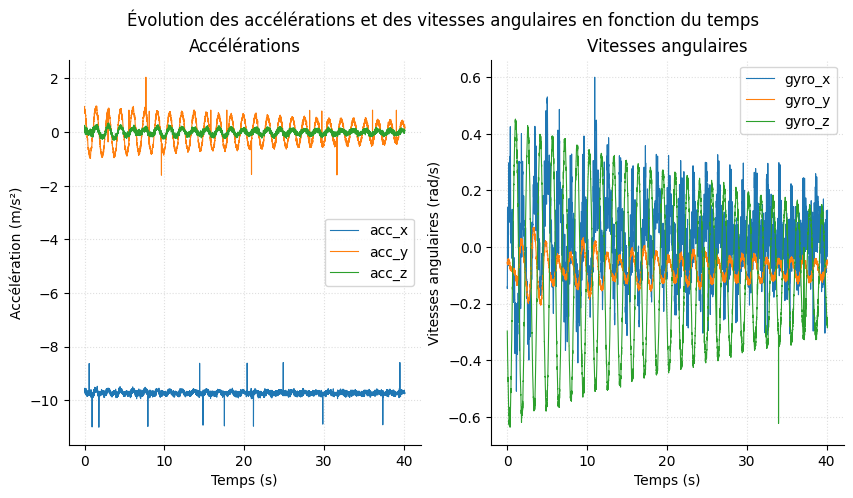

In [6]:
# Exploration des données
print("L’acquisition s’est terminée à t =", round(df["T"].iloc[-1], 1), "secondes")
print("Il y a", df.shape[0], "points dans les données")
print("La fréquence d’échantillonnage moyenne est de", round(df.shape[0] / df["T"].iloc[-1], 1), "Hz")

# Trace les données
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axs[0].plot(df["T"], df["acc_x"], label="acc_x", lw = 0.8)
axs[0].plot(df["T"], df["acc_y"], label="acc_y", lw = 0.8)
axs[0].plot(df["T"], df["acc_z"], label="acc_z", lw = 0.8)
axs[0].set_title("Accélérations")
axs[0].set_xlabel("Temps (s)")
axs[0].set_ylabel("Accélération (m/s²)")
axs[0].legend()
axs[0].grid(alpha = 0.4, ls = ':')
axs[0].spines[['top', 'right']].set_visible(False)

axs[1].plot(df["T"], df["gyro_x"], label="gyro_x", lw = 0.8)
axs[1].plot(df["T"], df["gyro_y"], label="gyro_y", lw = 0.8)
axs[1].plot(df["T"], df["gyro_z"], label="gyro_z", lw = 0.8)
axs[1].set_title("Vitesses angulaires")
axs[1].set_xlabel("Temps (s)")
axs[1].legend()
axs[1].set_ylabel("Vitesses angulaires (rad/s)")
axs[1].grid(alpha = 0.4, ls = ':')
axs[1].spines[['top', 'right']].set_visible(False)

fig.suptitle("Évolution des accélérations et des vitesses angulaires en fonction du temps")

plt.show()

## Interpolation

Afin de pouvoir réaliser une analyse fréquentielle du signal par transformée de Fourier, il est nécessaire d’interpoler les données brutes de manière à obtenir une fréquence d’échantillonnage constante et uniforme sur l’ensemble de la durée d’acquisition.

In [7]:
fs = 200 # fréquence d’échantillonnage souhaitée en Hz
t = df["T"].values # valeurs de temps brutes
t_uniform = np.arange(t[0], t[-1], 1/fs) # temps uniformément échantillonné

df_interpo = pd.DataFrame({"T": t_uniform})

# Interpolation de chaque colonne d'accélération
for col in df.columns:
    if col != "T":
        f = interp1d(df["T"], df[col].values, kind="linear", fill_value="extrapolate")
        df_interpo[col] = f(t_uniform)


## Moyenne glissante

Malgré l’interpolation, le signal mesuré demeure bruité du fait des imperfections de mesure de la centrale inertielle. Un lissage par moyenne glissante est donc appliqué afin d’atténuer les fluctuations rapides liées au bruit, tout en préservant la dynamique globale du mouvement. Ce prétraitement permet d’obtenir un signal plus stable et plus exploitable pour les analyses ultérieures.

In [8]:
cols = df_interpo.columns.drop("T")

df_interpo[cols] = df_interpo[cols].rolling(window=150, center=True, min_periods=1).mean()

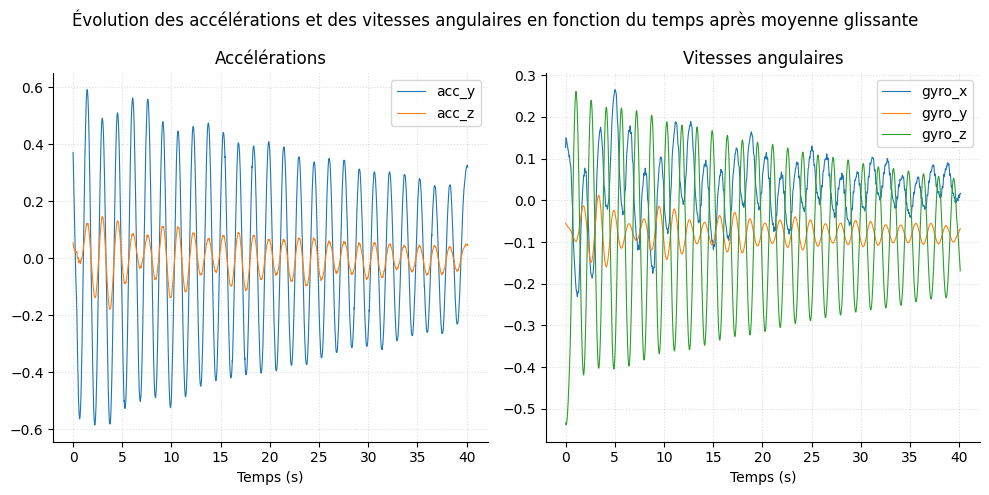

In [9]:
# Trace les données
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

#axs[0].plot(df_interpo["T"], df_interpo["acc_x"], label="acc_x")
axs[0].plot(df_interpo["T"], df_interpo["acc_y"], label="acc_y", lw = 0.8)
axs[0].plot(df_interpo["T"], df_interpo["acc_z"], label="acc_z", lw = 0.8)
axs[0].set_title("Accélérations")
axs[0].set_xlabel("Temps (s)")
axs[0].grid(alpha = 0.4, ls = ':')
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].legend()

axs[1].plot(df_interpo["T"], df_interpo["gyro_x"], label="gyro_x", lw = 0.8)
axs[1].plot(df_interpo["T"], df_interpo["gyro_y"], label="gyro_y", lw = 0.8)
axs[1].plot(df_interpo["T"], df_interpo["gyro_z"], label="gyro_z", lw = 0.8)
axs[1].set_title("Vitesses angulaires")
axs[1].set_xlabel("Temps (s)")
axs[1].grid(alpha = 0.4, ls = ':')
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].legend()

fig.suptitle("Évolution des accélérations et des vitesses angulaires en fonction du temps après moyenne glissante")

plt.tight_layout()
plt.show()


On remarque que les artefacts et le bruit de mesure ont bien été lissés. 

## Calcul de l'accélération tangentielle

La masse suspendue pouvant subir de légères rotations au cours de l’oscillation, l’accélération mesurée par le capteur n’est pas toujours portée par un axe unique. Afin de disposer d’une grandeur plus robuste vis-à-vis de ces variations d’orientation, on définit une accélération tangentielle à partir des composantes transverses de l’accélération.

Cette accélération tangentielle est définie par :

$$
a_{\mathrm{tan}}(t) = \sqrt{a_y(t)^2 + a_z(t)^2}\,\mathrm{sign}\!\left(a_y(t)\right),
$$

ce qui permet de conserver l’information sur le sens de l’oscillation tout en limitant la sensibilité à l’orientation instantanée du capteur. Cette grandeur est ensuite utilisée pour l’analyse temporelle et fréquentielle du mouvement du pendule.

En fonction de l'allure des signaux, on laisse la possibilité à l'utilisateur ou l'utilisatrice d'utiliser la variable qu'iel préfère. 

In [10]:
# df_interpo["acc_tan"] = np.sqrt(df_interpo["acc_y"]**2 + df_interpo["acc_z"]**2) * np.sign(df_interpo["acc_y"])
df_interpo["acc_tan"] = df_interpo["acc_y"]

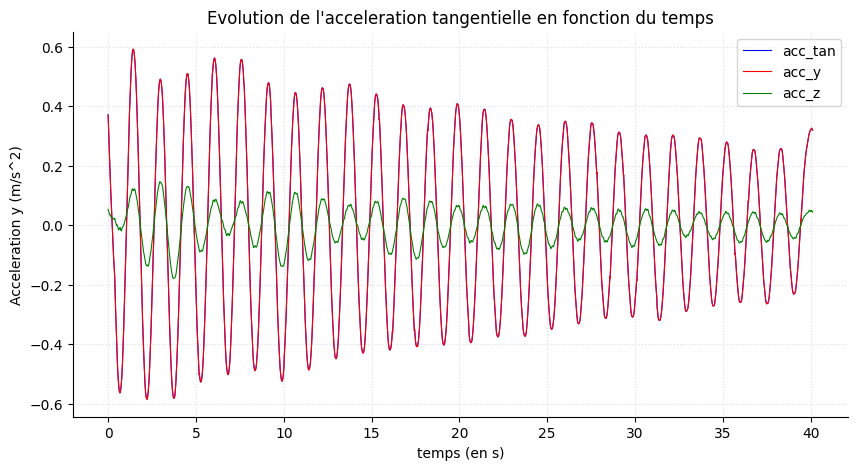

In [11]:
# Tracé de l'accélération tangentielle en fonction du temps 
plt.figure(figsize=(10,5))
plt.plot(df_interpo["T"],df_interpo["acc_tan"],'b', label='acc_tan', lw = 0.8)
plt.plot(df_interpo["T"],df_interpo["acc_y"],'r', label='acc_y', lw = 0.8)
plt.plot(df_interpo["T"],df_interpo["acc_z"],'g', label='acc_z', lw = 0.8)
plt.ylabel('Acceleration y (m/s^2)')
plt.xlabel('temps (en s)')
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.title("Evolution de l'acceleration tangentielle en fonction du temps")
plt.show()


# Détermination de la période

La période d’oscillation du pendule est déterminée à l’aide de deux méthodes complémentaires. Dans un premier temps, une approche temporelle est utilisée, fondée sur l’identification des passages par zéro du signal mesuré. Dans un second temps, une analyse fréquentielle par transformée de Fourier permet d’identifier la fréquence dominante du mouvement. Les périodes obtenues par ces deux méthodes sont ensuite comparées entre elles, puis confrontées à la valeur théorique prédite par le modèle du pendule simple.

## Détermination temporelle

Afin de déterminer temporellement la période d’oscillation du pendule, on identifie les instants correspondant aux passages par zéro de l’accélération tangentielle. La période est ensuite estimée à partir des intervalles de temps séparant ces passages successifs.

In [12]:
# Signal d'accélération tangentielle
t = df_interpo["T"].values
acc_tan = df_interpo["acc_tan"].values

# Détection des passages par zéro
zc_idx = np.where(np.diff(np.sign(acc_tan)) != 0)[0]
t_zc = t[zc_idx]

# Intervalles entre passages par zéro
dt_zc = np.diff(t_zc)

# Une période correspond à deux passages par zéro
periods = 2 * dt_zc

print(
    "La période moyenne du pendule sur la durée de l'enregistrement est de :",
    round(periods.mean(), 2),
    "s"
)

La période moyenne du pendule sur la durée de l'enregistrement est de : 1.54 s


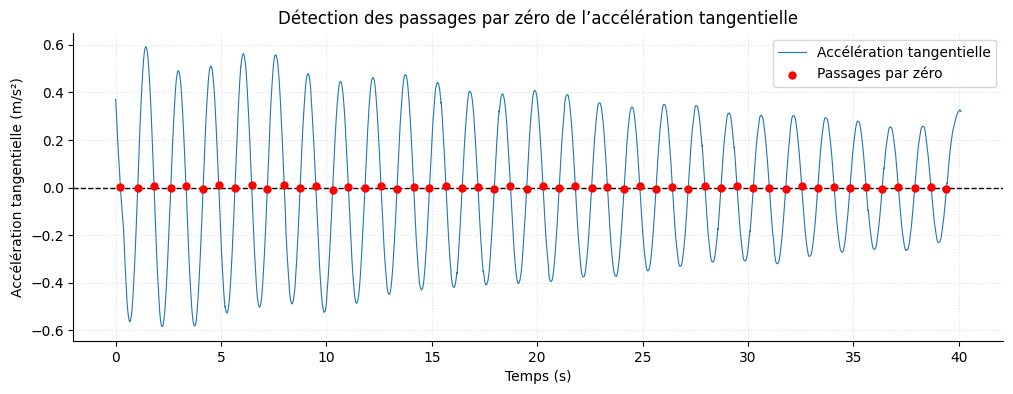

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(t, acc_tan, label="Accélération tangentielle", lw = 0.8, color = "tab:blue")
plt.scatter(t_zc, acc_tan[zc_idx], color="red", s=25,
            label="Passages par zéro", zorder=3)
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Temps (s)")
plt.ylabel("Accélération tangentielle (m/s²)")
plt.title("Détection des passages par zéro de l’accélération tangentielle")
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()


La détection des passages par zéro est donc cohérente. 

## Détermination fréquentielle

La détermination fréquentielle de la période est réalisée à partir de la transformée de Fourier du signal d’accélération tangentielle interpolé. La transformée de Fourier discrète permet d’obtenir le spectre d’amplitude du signal en fonction de la fréquence. La fréquence dominante correspond au pic principal du spectre, hors composante continue. Cette fréquence est associée au mouvement oscillatoire du pendule. La période d’oscillation est alors déduite comme l’inverse de cette fréquence dominante. Cette approche fréquentielle constitue une méthode complémentaire à l’analyse temporelle, et permet de vérifier la cohérence des résultats obtenus.

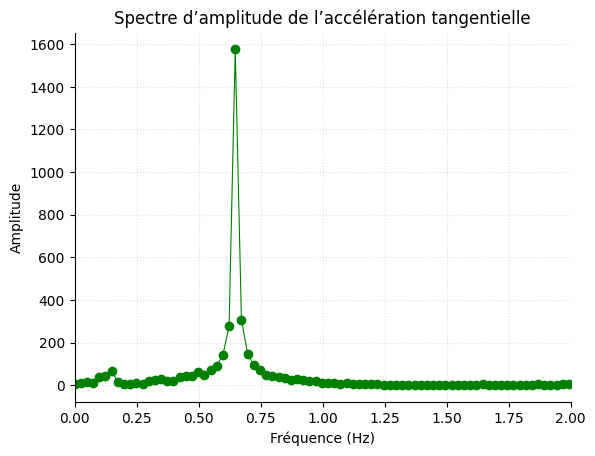

La fréquence dominante du signal est : 0.65 Hz
La période associée est : 1.54 s, en comparaison avec la période temporelle calculée précédemment :  1.54 s


In [14]:
# Extraction du temps et du signal d’accélération interpolé
tps = np.array(df_interpo["T"])
acc = np.array(df_interpo["acc_tan"])

# Paramètres d’échantillonnage
N = len(acc)        # Nombre de points
dt = 1 / fs           # Pas de temps (s)

# Calcul de la transformée de Fourier 
ff = np.fft.rfftfreq(N, dt)        # Axe des fréquences
Fyy = np.abs(np.fft.rfft(acc))   # Amplitude du spectre

# Tracé du spectre d’amplitude
plt.figure()
plt.plot(ff, Fyy, "go-", lw = 0.8)
plt.xlim(0, 2)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.title("Spectre d’amplitude de l’accélération tangentielle")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

# Détermination de la fréquence dominante (hors composante continue)
idx_peak = np.argmax(Fyy[1:]) + 1  # On ignore la fréquence nulle
freq = ff[idx_peak]

print("La fréquence dominante du signal est :", round(freq,2), "Hz")
print("La période associée est :", round(1 / freq,2), "s, en comparaison avec la période temporelle calculée précédemment : ", round(periods.mean(),2), "s")


La comparaison des périodes obtenues par les méthodes temporelle et fréquentielle permet de vérifier la cohérence des résultats expérimentaux. Enfin, ces valeurs sont comparées à la période théorique du pendule simple, donnée par

$$
T = 2\pi \sqrt{\frac{l}{g}},
$$

afin d’évaluer l’accord entre le modèle théorique et les mesures expérimentales.


In [15]:
T = 2*np.pi*np.sqrt(l/9.81)

print("La période théorique du pendule est de :", round(T,2), "s, on a donc une différence de :", round(abs(T - periods.mean()),2), "s, soit environ", round(abs(T - periods.mean())/T*100,1), "%.")

La période théorique du pendule est de : 1.55 s, on a donc une différence de : 0.02 s, soit environ 1.1 %.


# Reconstruction du mouvement

Cette partie vise à reconstruire le mouvement du pendule à partir de l’accélération mesurée, depuis l’accélération tangentielle jusqu’à l’estimation de l’angle. Les différentes méthodes de reconstruction de l’angle sont comparées entre elles afin d’évaluer leur cohérence et l’impact de la modélisation sur la qualité des résultats.

## Reconstruction géométrique

Dans cette partie, l’angle du pendule est reconstruit par une approche géométrique, en exploitant la direction du champ de pesanteur mesurée par l’accéléromètre, indépendamment de l’intégration temporelle des signaux.

/var/folders/fn/kh0hs_lj1qs9grxczvwq5vq40000gn/T/ipykernel_64742/1175141619.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(df_interpo["T"], theta_centered, "b", lw = 0.8, color = "tab:purple")


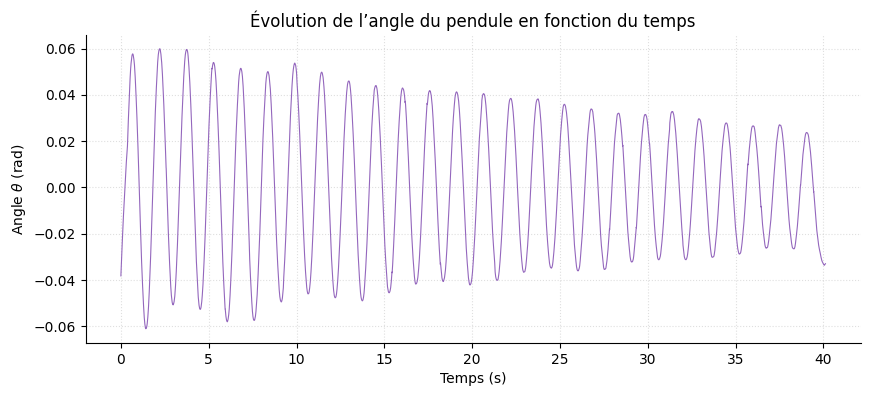

In [16]:
# Accélération de la pesanteur (m/s²)
g = 9.81

# Estimation de l’angle du pendule à partir des composantes de l’accélération
# L’angle est déterminé par la direction du vecteur accélération mesuré
theta = np.arctan2(df_interpo["acc_tan"], df_interpo["acc_x"])

# Déroulement du signal angulaire afin de supprimer les discontinuités de ±π
theta_unwrapped = np.unwrap(theta)

# Recentrage de l’angle pour supprimer l’offset constant lié à la référence angulaire
theta_centered = theta_unwrapped - np.mean(theta_unwrapped)

# Tracé de l’évolution temporelle de l’angle du pendule
plt.figure(figsize=(10, 4))
plt.plot(df_interpo["T"], theta_centered, "b", lw = 0.8, color = "tab:purple")
plt.xlabel("Temps (s)")
plt.ylabel(r"Angle $\theta$ (rad)")
plt.title("Évolution de l’angle du pendule en fonction du temps")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()


## Modélisation de l’accélération du pendule par un sinus amorti

Pour de faibles amplitudes, le mouvement d’un pendule simple peut être assimilé à celui d’un oscillateur harmonique. Dans l’approximation des petits angles, l’équation du mouvement est linéaire et conduit à une solution sinusoïdale. En présence de frottements (résistance de l’air, frottements au point d’attache), l’amplitude des oscillations décroît progressivement au cours du temps, ce qui se traduit par une enveloppe exponentielle.

L’accélération du pendule, comme la position et la vitesse, conserve alors une forme sinusoïdale dont l’amplitude décroît avec le temps. Il est donc pertinent de modéliser l’accélération tangentielle par un sinus amorti, que l’on peut écrire sous la forme

$$
a(t) = A\,\mathrm{e}^{-t/\tau}\,\sin\!\left(2\pi f\,t + \phi\right),
$$

où $A$ est l’amplitude initiale, $f$ la fréquence d’oscillation, $\phi$ la phase initiale et $\tau$ la constante de temps caractérisant l’amortissement.


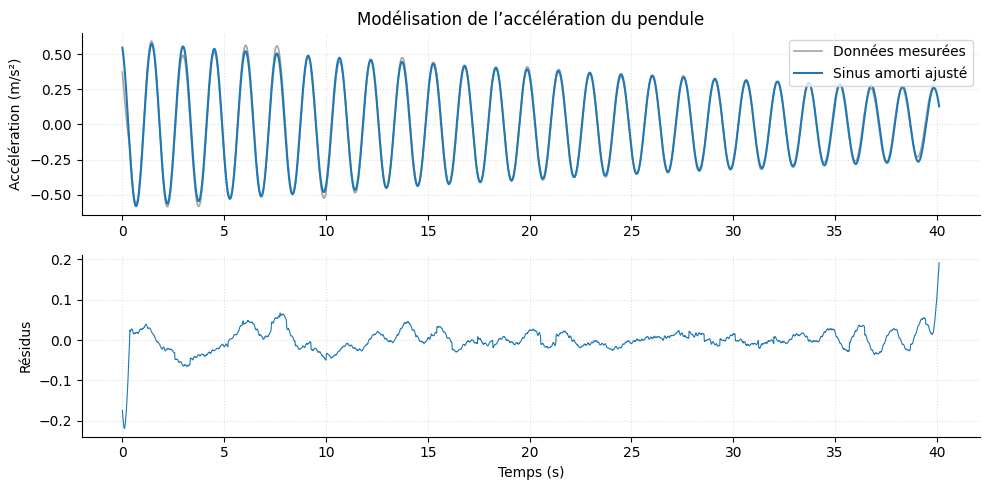

In [17]:
# Extraction du temps et de l’accélération tangentielle
tps = df_interpo["T"].to_numpy()
acc_tan = df_interpo["acc_tan"].to_numpy()

# -----------------------------
# Initialisation des paramètres du modèle
# -----------------------------

# Fréquence initiale estimée à partir de la FFT
guess_freq = freq                      # Hz

# Amplitude initiale estimée à partir du signal
guess_amplitude = (acc_tan.max() - acc_tan.min()) / 2

# Phase initiale
guess_phase = 0

# Offset moyen du signal
guess_offset = np.mean(acc_tan)

# Constante de temps d’amortissement (ordre de grandeur)
guess_tau = 20 # s

# Paramètres initiaux pour l’ajustement
p0 = [guess_freq, guess_amplitude, guess_phase, guess_offset, guess_tau]

# -----------------------------
# Définition du modèle : sinus amorti
# -----------------------------
def my_sinam(t, freq, amplitude, phase, offset, tau):
    return amplitude * np.exp(-t / tau) * np.sin(2 * np.pi * freq * t + phase) + offset

# -----------------------------
# Ajustement du modèle aux données
# -----------------------------

# Bornes sur les paramètres pour contraindre l’ajustement
bounds = (
    [0.5 * guess_freq,      0,   -2*np.pi, -np.inf,   1.0],   # bornes inférieures
    [2.0 * guess_freq, np.inf,    2*np.pi,  np.inf, 200.0]    # bornes supérieures
)

# Ajustement par moindres carrés non linéaires
popt, pcov = curve_fit(
    my_sinam,
    tps,
    acc_tan,
    p0=p0,
    bounds=bounds,
    maxfev=20000
)

# Extraction des paramètres ajustés
f_fit, A_fit, phi_fit, offset_fit, tau_fit = popt

# Signal modélisé et résidus
acc_fit = my_sinam(tps, *popt)
acc_fit = acc_fit - np.mean(acc_fit) 
residus = acc_tan - acc_fit

# -----------------------------
# Visualisation des résultats
# -----------------------------
plt.figure(figsize=(10, 5))

# Comparaison données / modèle
plt.subplot(2, 1, 1)
plt.plot(tps, acc_tan, label="Données mesurées", alpha=0.7, lw = 1.2, color = "tab:grey")
plt.plot(tps, acc_fit, label="Sinus amorti ajusté", lw=1.5, color = "tab:blue")
plt.legend()
plt.ylabel("Accélération (m/s²)")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.title("Modélisation de l’accélération du pendule")

# Résidus de l’ajustement
plt.subplot(2, 1, 2)
plt.plot(tps, residus, lw = 0.8)
plt.ylabel("Résidus")
plt.xlabel("Temps (s)")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


La figure présente la modélisation de l’accélération du pendule par un sinus amorti ajusté aux données expérimentales. Le signal modélisé reproduit fidèlement la dynamique observée, tant en fréquence qu’en phase, ainsi que la décroissance progressive de l’amplitude liée à l’amortissement du système.

Les résidus de l’ajustement, représentés sur le second graphe, sont globalement centrés autour de zéro et ne présentent pas de structure périodique marquée, ce qui indique que l’essentiel du comportement oscillatoire est correctement capturé par le modèle. Les fluctuations restantes peuvent être attribuées au bruit de mesure de la centrale inertielle et aux effets non modélisés, tels que les frottements non linéaires ou les imperfections du montage expérimental.

## Calcul, modélisation de la vitesse

On intègre l'accélération modélisée pour obtenir la vitesse. 

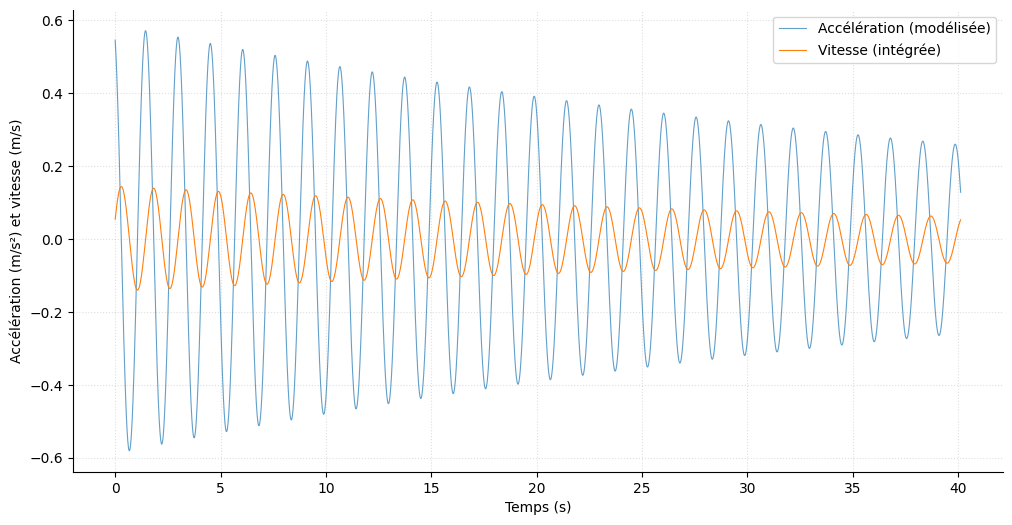

In [18]:
# Intégration de l’accélération modélisée pour obtenir la vitesse
v_int = cumulative_trapezoid(acc_fit, tps, initial=0)

# Recentrage de la vitesse : suppression de la constante d’intégration
v_tan = v_int - np.mean(v_int)

# Tracé de l’accélération et de la vitesse en fonction du temps
plt.figure(figsize=(12, 6))
plt.plot(tps, acc_fit, label="Accélération (modélisée)", alpha=0.7, lw = 0.8, color = "tab:blue")
plt.plot(tps, v_tan, label="Vitesse (intégrée)", lw = 0.8, color = "tab:orange")
plt.xlabel("Temps (s)")
plt.ylabel("Accélération (m/s²) et vitesse (m/s)")
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()


Tout comme pour l'accélération, on ajuste un modèle de sinus amorti à la courbe de vitesse.

/Users/tim/Documents/Phyling/git/PhylingApp/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


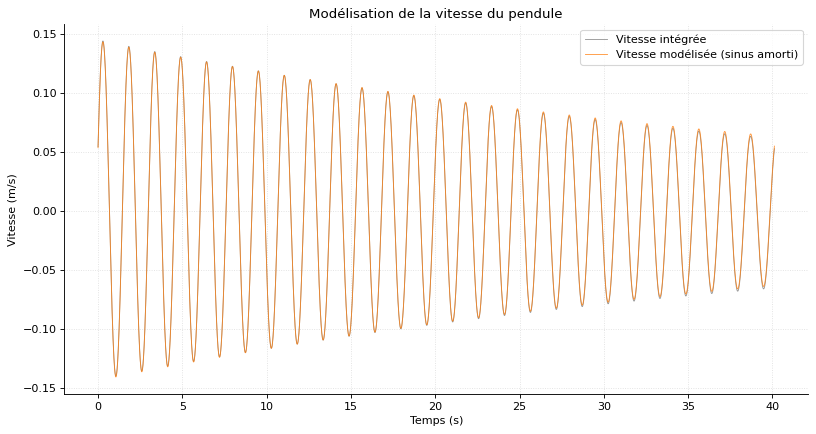

Fréquence ajustée : 0.651 Hz
Amplitude initiale : -0.144 m/s
Constante de temps τ : 48.83 s


In [19]:
# -----------------------------
# Données : temps et vitesse intégrée
# -----------------------------
tps = df_interpo["T"].to_numpy()
v_tan = v_tan  # vitesse obtenue par intégration de l’accélération

# -----------------------------
# Estimation des paramètres initiaux
# -----------------------------

# Fréquence identique à celle obtenue pour l’accélération
guess_freq = f_fit

# Amplitude estimée à partir du signal
guess_amplitude = (v_tan.max() - v_tan.min()) / 2

# Déphasage attendu entre vitesse et accélération
guess_phase = phi_fit + np.pi / 2

# Offset moyen de la vitesse
guess_offset = np.mean(v_tan)

# Constante de temps identique à celle de l’accélération
guess_tau = tau_fit

# Paramètres initiaux
p0 = [guess_freq, guess_amplitude, guess_phase, guess_offset, guess_tau]

# -----------------------------
# Ajustement du modèle à la vitesse
# -----------------------------
popt_v, pcov_v = curve_fit(
    my_sinam,
    tps,
    v_tan,
    p0=p0,
    maxfev=50000
)

# Paramètres ajustés
f_v, A_v, phi_v, offset_v, tau_v = popt_v

# Signal de vitesse modélisé
v_fit = my_sinam(tps, *popt_v)

# -----------------------------
# Tracé : données vs modèle
# -----------------------------
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(tps, v_tan, label="Vitesse intégrée", alpha=0.8, lw = 0.8, color = "tab:grey")
plt.plot(tps, v_fit, label="Vitesse modélisée (sinus amorti)", alpha = 0.8, lw = 0.8, color = "tab:orange")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse (m/s)")
plt.title("Modélisation de la vitesse du pendule")
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

# -----------------------------
# Résultats numériques
# -----------------------------
print(f"Fréquence ajustée : {f_v:.3f} Hz")
print(f"Amplitude initiale : {A_v:.3f} m/s")
print(f"Constante de temps τ : {tau_v:.2f} s")


## Calcul de la position

On intègre la vitesse afin d'obtenir la position du pendule. 

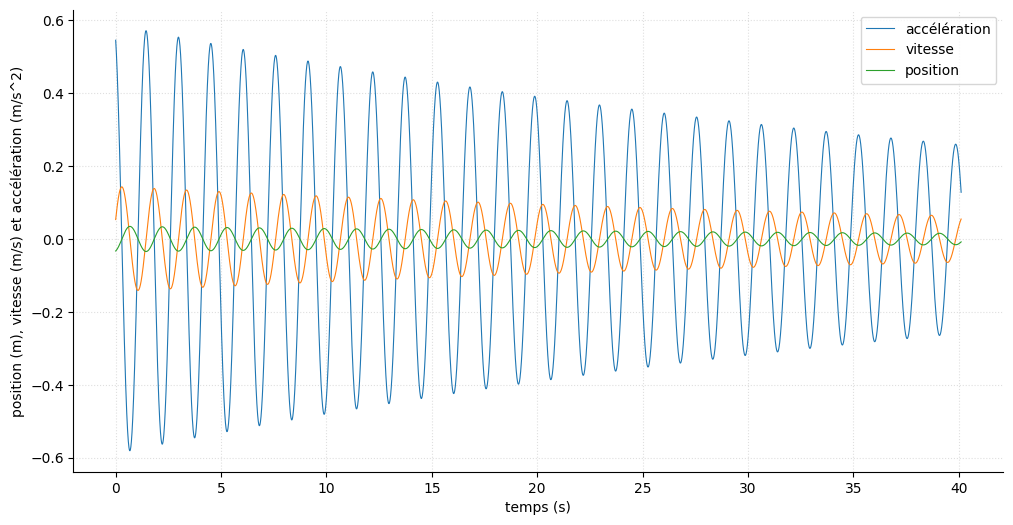

In [20]:
y_int = cumulative_trapezoid(v_fit, tps, initial=0)
y_int=y_int-np.mean(y_int)
plt.figure(figsize=(12,6))

plt.plot(tps,acc_fit, label='accélération', lw = 0.8, color = "tab:blue")
plt.plot(tps, v_fit, label='vitesse', lw = 0.8, color = "tab:orange")
plt.plot(tps,y_int, label='position', lw = 0.8, color = "tab:green")
plt.xlabel('temps (s)')
plt.ylabel('position (m), vitesse (m/s) et accélération (m/s^2)')
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

## Comparaison des calculs des angles

Dans cette partie, l’angle du pendule est reconstruit à partir du déplacement linéaire obtenu par intégration, en utilisant l’approximation des petits angles 
$$
\theta \approx \frac{y}{l},
$$
où $l$ désigne la longueur du pendule. Cette estimation est ensuite comparée à l’angle obtenu directement à partir des mesures de la centrale inertielle, calculé à partir de la direction du champ de pesanteur. La comparaison des deux signaux permet d’évaluer la cohérence des méthodes de reconstruction de l’angle.


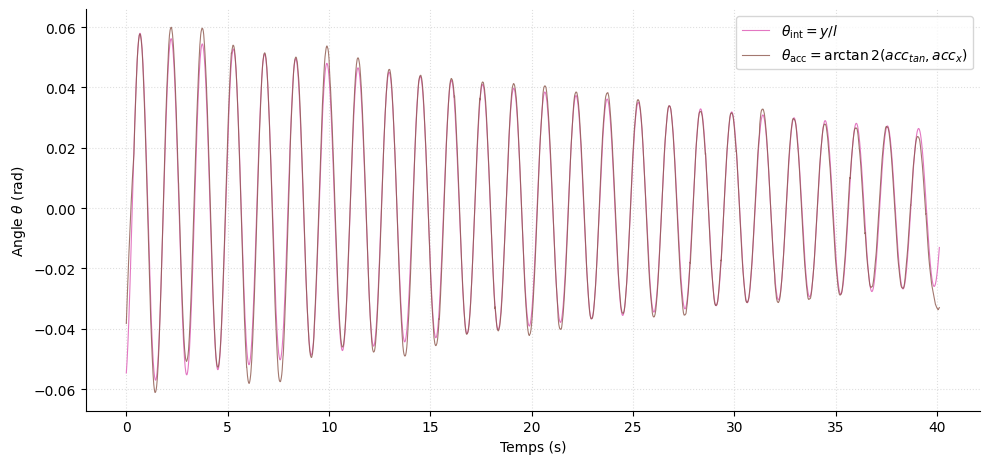

In [21]:
# Reconstruction de theta à partir de y (petits angles)
theta_int = y_int / l  

# Comparaison graphique
plt.figure(figsize=(10, 5))

plt.plot(tps, theta_int, label=r"$\theta_{\mathrm{int}} = y/l$", lw = 0.8, color = "tab:pink")
plt.plot(tps, theta_centered, label=r"$\theta_{\mathrm{acc}} = \arctan2(acc_{tan}, acc_x)$", alpha=0.8, lw = 0.8, color = "tab:brown")
plt.xlabel("Temps (s)")
plt.ylabel(r"Angle $\theta$ (rad)")
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)

fig.suptitle("Reconstruction de la position et comparaison des estimations de l’angle")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


La comparaison des deux reconstructions de l’angle du pendule met en évidence une très bonne cohérence entre l’angle obtenu par intégration du déplacement, dans l’approximation des petits angles, et l’angle estimé à partir des mesures d’accélération. Les deux signaux présentent la même période, la même phase et une décroissance d’amplitude comparable liée à l’amortissement du système. Les légères différences d’amplitude observées pourraient s’expliquer par une modélisation par sinus amorti imparfaite, dont les erreurs sont décuplées par intégration, et par l’influence du bruit de mesure. Ces résultats confirment la pertinence de la reconstruction du mouvement et la cohérence globale des approches employées.

## Comparaison avec et sans modélisation par des sinus amortis 

Dans cette partie, on souhaite comparer les résultats d'intégration de l'accélération de la vitesse avec et sans modélisation par sinus amorti, afin de mettre en évidence la pertinence des modélisations. 

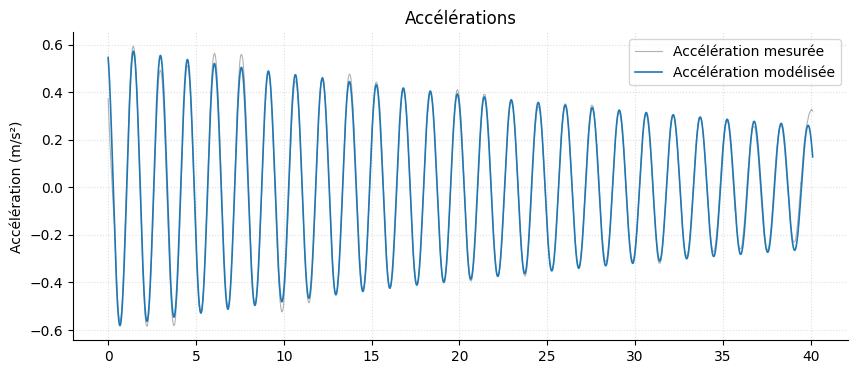

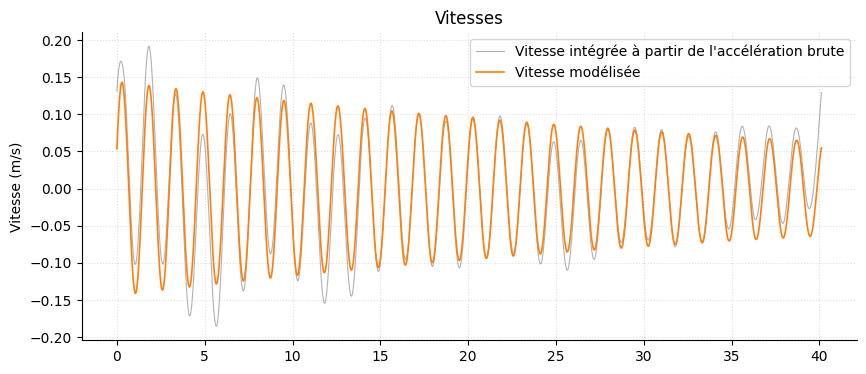

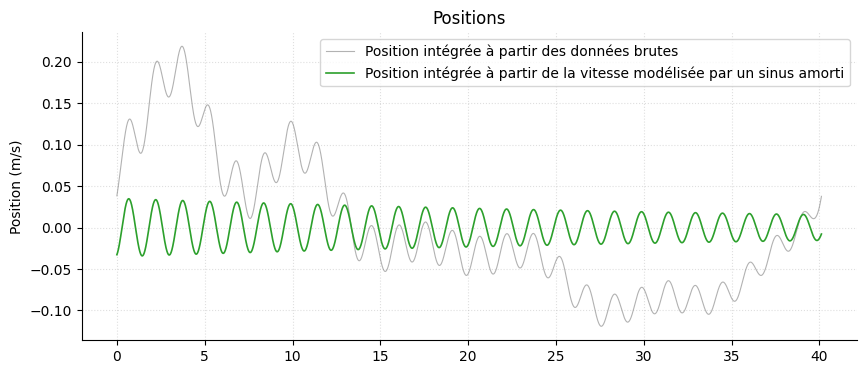

In [22]:
acc_tan = df_interpo["acc_tan"].to_numpy()
tps = df_interpo["T"].to_numpy()

acc_meas = acc_tan - np.mean(acc_tan)

v_meas = cumulative_trapezoid(acc_meas, tps, initial=0)
v_meas = v_meas - np.mean(v_meas)

y_meas = cumulative_trapezoid(v_meas, tps, initial=0)
y_meas = y_meas - np.mean(y_meas)

plt.figure(figsize=(10,4))
plt.plot(tps, acc_meas, label="Accélération mesurée", alpha=0.6, lw = 0.8, color = "tab:grey")
plt.plot(tps, acc_fit, label="Accélération modélisée", linewidth=1.2, color = "tab:blue")
plt.legend()
plt.ylabel("Accélération (m/s²)")
plt.title("Accélérations")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(tps, v_meas, label="Vitesse intégrée à partir de l'accélération brute", alpha=0.6, lw = 0.8, color = "tab:grey")
plt.plot(tps, v_fit, label="Vitesse modélisée", linewidth=1.2, color = "tab:orange")
plt.legend()
plt.ylabel("Vitesse (m/s)")
plt.title("Vitesses")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(tps, y_meas, label="Position intégrée à partir des données brutes", alpha=0.6, lw = 0.8, color = "tab:grey")
plt.plot(tps, y_int, label="Position intégrée à partir de la vitesse modélisée par un sinus amorti", linewidth=1.2, color = "tab:green")
plt.legend()
plt.ylabel("Position (m/s)")
plt.title("Positions")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

La comparaison des positions reconstruites met en évidence une **différence marquée** entre l’intégration directe des données brutes et l’intégration de la vitesse modélisée par un sinus amorti. La position obtenue à partir des données brutes présente une dérive et des fluctuations importantes, caractéristiques de l’amplification du bruit et des offsets lors des intégrations successives. À l’inverse, la position reconstruite à partir de la vitesse modélisée reste stable et cohérente avec la dynamique attendue du pendule, tant en fréquence qu’en amplitude.

Ces résultats soulignent **l’intérêt d’une étape de modélisation préalable avant intégration**, afin de limiter l’accumulation des erreurs et d’obtenir une reconstruction plus fiable du mouvement.

# Portrait de phase

Afin d’analyser la dynamique du pendule de manière globale et indépendante du temps, on représente le portrait de phase du système, qui consiste à tracer la vitesse en fonction de la position. Cette représentation permet de visualiser directement la structure du mouvement, l’évolution de l’énergie mécanique et les effets de l’amortissement.

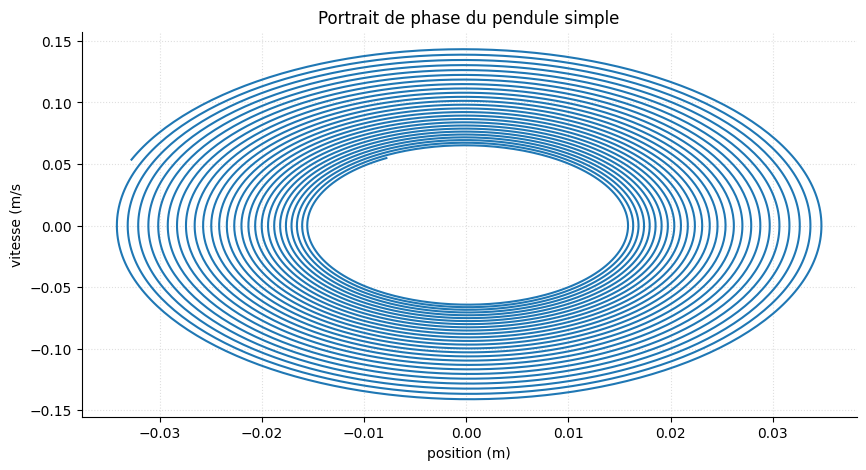

In [23]:
plt.figure(figsize=(10,5))
plt.plot(y_int,v_fit)
plt.xlabel('position (m)')
plt.ylabel('vitesse (m/s')
plt.title("Portrait de phase du pendule simple")
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.show()

Le portrait de phase obtenu présente des trajectoires fermées progressivement contractées vers l’origine, traduisant un mouvement oscillatoire amorti. La forme quasi elliptique des trajectoires est caractéristique d’un pendule simple dans l’approximation des petits angles. La diminution progressive de l’aire des boucles au cours du temps témoigne de la dissipation d’énergie mécanique due aux frottements. Ce portrait de phase confirme ainsi la cohérence du modèle retenu et la validité de la reconstruction du mouvement du pendule.

# Analyse énergétique du pendule simple

Dans cette partie, l’évolution énergétique du pendule est étudiée à partir des grandeurs reconstruites précédemment. Les énergies cinétique et potentielle sont calculées en fonction du temps, dans l’approximation des petits angles, puis combinées afin d’obtenir l’énergie mécanique du système. Cette analyse permet de mettre en évidence les échanges d’énergie entre les formes cinétique et potentielle, ainsi que la décroissance progressive de l’énergie mécanique due aux phénomènes dissipatifs.

f = 0.65 Hz
l = 0.6 m


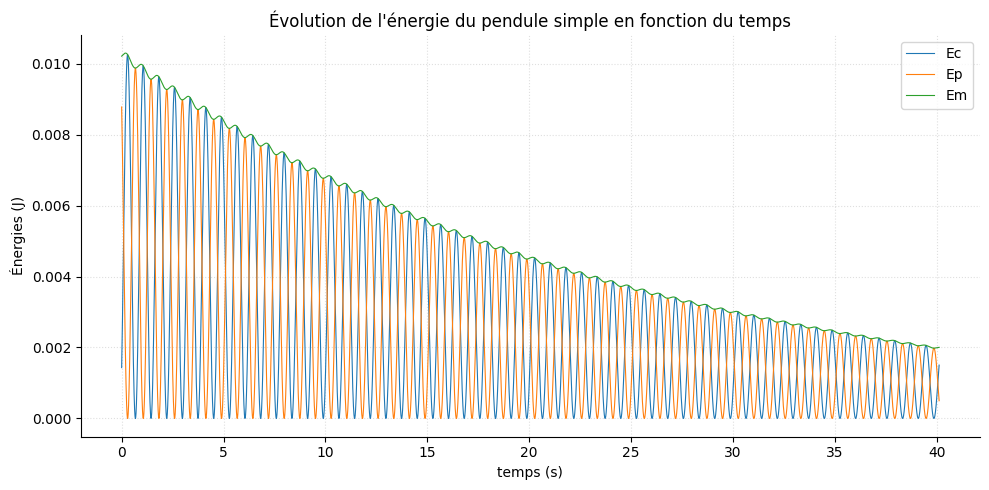

In [24]:
# Longueur du pendule à partir de la période
T = 1 / freq
print("f =", round(freq,2), "Hz")
print("l =", round(l,2), "m")

# Énergies
Ec = 0.5 * m * v_fit**2

Ep = m * g / (2 * l) * y_int**2 # approximation des petits angles, DL du cosinus

Em = Ec + Ep

plt.figure(figsize=(10,5))

plt.plot(tps, Ec, label="Ec", lw = 0.8)
plt.plot(tps, Ep, label="Ep", lw = 0.8)
plt.plot(tps, Em, label="Em", lw = 0.8)
plt.xlabel('temps (s)')
plt.ylabel('Énergies (J)')
plt.title("Évolution de l'énergie du pendule simple en fonction du temps")
plt.legend()
plt.grid(alpha = 0.4, ls = ':')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


L’évolution temporelle des énergies cinétique et potentielle met en évidence des échanges périodiques caractéristiques du mouvement oscillatoire du pendule. Lorsque l’une des énergies est maximale, l’autre est minimale, traduisant la conversion continue entre énergie cinétique et énergie potentielle au cours du mouvement.

L’énergie mécanique, correspondant à la somme des deux contributions, décroît progressivement au cours du temps, ce qui témoigne de la présence de phénomènes dissipatifs, tels que les frottements et les pertes par résistance de l’air. Cette décroissance quasi exponentielle est cohérente avec le comportement d’un pendule amorti et confirme la pertinence des hypothèses et des reconstructions effectuées tout au long de l’étude.

# Conclusion

Ce travail a permis d’étudier expérimentalement le mouvement d’un pendule simple à l’aide d’une centrale inertielle. À partir des mesures d’accélération et de vitesse angulaire, différentes méthodes d’analyse ont été mises en œuvre afin de caractériser la dynamique du système.

L’analyse temporelle et fréquentielle a permis de déterminer la période d’oscillation du pendule et d’en déduire sa longueur, en bon accord avec le modèle théorique du pendule simple dans l’approximation des petits angles. La modélisation de l’accélération et de la vitesse par des sinusoïdes amorties a fourni une description analytique cohérente du mouvement et a permis de limiter l’amplification du bruit lors des intégrations successives.

La reconstruction du déplacement et de l’angle du pendule par différentes approches a mis en évidence une bonne cohérence globale des résultats, tant en phase qu’en période, malgré des écarts attendus liés aux hypothèses de modélisation et aux limites des capteurs. L’analyse énergétique et le portrait de phase ont confirmé le caractère oscillatoire amorti du système et la dissipation progressive de l’énergie mécanique.

Ce TP met ainsi en évidence l’intérêt de combiner mesures expérimentales, modélisation et outils de traitement du signal pour analyser finement le comportement dynamique d’un système mécanique simple.